In [84]:
import findspark 
findspark.init(r'C:\spark\spark-3.1.2-bin-hadoop3.2')
findspark.find()

'C:\\spark\\spark-3.1.2-bin-hadoop3.2'

Import các thư viện cần thiết 

In [85]:
import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit
from pyspark.sql import functions as Fnc
from pyspark.sql.window import Window
import seaborn as sns
import random
from pprint import pprint
from pyspark.sql import functions as func
from pyspark.sql.functions import monotonically_increasing_id
%matplotlib inline
sns.set_style("darkgrid")
from pyspark.sql.functions import round
from pyspark.sql.types import *
from pandas.plotting import scatter_matrix
import ast
from pyspark.sql.functions import udf, array
from pyspark.sql.functions import col
from pyspark.sql.types import StringType,DoubleType

from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("BigData").getOrCreate()


Tiến hành đọc dữ liệu data đầu vào và tạo kiểu dữ liệu thuộc tính là struct type 

In [86]:
data = StructType([
    StructField("longitude", DoubleType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("housing_median_age", DoubleType(), True),
    StructField("total_rooms", DoubleType(), True),
    StructField("total_bedrooms", DoubleType(), True),
    StructField("population", DoubleType(), True),
    StructField("households", DoubleType(), True),
    StructField("median_income", DoubleType(), True),
    StructField("median_house_value", DoubleType(), True),
    StructField("ocean_proximity", DoubleType(), True),
])

data_train = spark.read.csv(r"D:\BigData\Project_Bigdata\housing_train.csv", sep =",", header=True, schema=data,inferSchema=True, nullValue = 'NA').limit(6000)

data_test = spark.read.csv(r"D:\BigData\Project_Bigdata\housing_test.csv", sep =",", header=True, schema=data,inferSchema=True, nullValue = 'NA').limit(1000)
# show data train 
data_train.show(10)

#show data test
data_test.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|           null|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|           null|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|           null|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|           null|
|  -114.57|   33.57|              

Sau đó ta sẽ tiến hành tạo nhãn nhị phân và gía trị 265000 là giá trị nằm trong khoan giá trị cột median_house_value, giá nhà trên mức này --> gán = 1 (cao), giá nhà thấp hơn mức này gọi là giá thấp(=0)

In [87]:
# Create label 
threshold = 265000
# Kiểm tra nếu giá trị của cột median_house_value
median_house_value_high = (Fnc.when(Fnc.col("median_house_value") < threshold, 0).when(Fnc.col("median_house_value") >= threshold, 1))

# Drop cột median_house và và thay vào đó là cột median_house_value
data_test = data_test.withColumn("median_house_value_high", median_house_value_high).drop('median_house_value')
data_train = data_train.withColumn("median_house_value_high", median_house_value_high).drop('median_house_value')

data_test.show(5)
data_train.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|ocean_proximity|median_house_value_high|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------------+-----------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|           null|                      1|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|           null|                      0|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       5.7934|           null|                      1|
|  -118.36|   33.82|              28.0|       67.0|          15.0|      49.0|      11.0|       6.1359|           null|                      1|

Ta tiến hành xem thử mean của cột mới là median_house_value_high là bao nhiêu
#mean trả về giá trị trung bình của cột là bao nhiêu 

In [88]:
from pyspark.sql.functions import mean as _mean, col 

data_train.select(
    _mean(col("median_house_value_high")).alias("meanof_median_house_value_high")
).show()

+------------------------------+
|meanof_median_house_value_high|
+------------------------------+
|           0.18766666666666668|
+------------------------------+



In [89]:
data_train.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   longitude                6000 non-null   float64
 1   latitude                 6000 non-null   float64
 2   housing_median_age       6000 non-null   float64
 3   total_rooms              6000 non-null   float64
 4   total_bedrooms           6000 non-null   float64
 5   population               6000 non-null   float64
 6   households               6000 non-null   float64
 7   median_income            6000 non-null   float64
 8   ocean_proximity          0 non-null      float64
 9   median_house_value_high  6000 non-null   int32  
dtypes: float64(9), int32(1)
memory usage: 445.4 KB


Đếm số dòng trong cột dữ liệu 

In [90]:
data_train.count()

6000

In [91]:
data_test.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   longitude                1000 non-null   float64
 1   latitude                 1000 non-null   float64
 2   housing_median_age       1000 non-null   float64
 3   total_rooms              1000 non-null   float64
 4   total_bedrooms           1000 non-null   float64
 5   population               1000 non-null   float64
 6   households               1000 non-null   float64
 7   median_income            1000 non-null   float64
 8   ocean_proximity          0 non-null      float64
 9   median_house_value_high  1000 non-null   int32  
dtypes: float64(9), int32(1)
memory usage: 74.3 KB


In [92]:
data_test.count()

1000

In [93]:
from pyspark.sql.functions import rand
data_train=data_train.orderBy(rand())
data_train.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|ocean_proximity|median_house_value_high|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------------+-----------------------+
|  -117.81|   34.12|              23.0|     7063.0|        1176.0|    3100.0|    1112.0|       4.8229|           null|                      0|
|   -117.9|   33.88|              28.0|     2696.0|         346.0|     947.0|     356.0|       9.0055|           null|                      1|
|   -118.2|   33.99|              30.0|     1474.0|         459.0|    1844.0|     464.0|        2.551|           null|                      0|
|  -117.45|    34.1|               9.0|     4288.0|        1017.0|    3156.0|     900.0|       2.7827|           null|                      0|

Ta tiến hành đưa các giá trị của cột về trong khoảng từ 0 đến 1 giúp bình đẳng các cột ảnh hướng lên kết quả dự báo 

In [94]:
# Min max scaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

columns = ["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value_high"]

# Function just to convert to help build data frame
def extract(row):
    return tuple(row.scaledFeatures.toArray().tolist())

def min_max_scaler(sdf, cols_to_scale, cols_to_keep_unscaled):
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    assembler = VectorAssembler().setInputCols(cols_to_scale).setOutputCol("features")
    sdf_transformed = assembler.setHandleInvalid("skip").transform(sdf)
    scaler_model = scaler.fit(sdf_transformed.select("features"))
    sdf_scaled = scaler_model.transform(sdf_transformed)

    sdf_scaled = sdf_scaled.select(*cols_to_keep_unscaled, "scaledFeatures").rdd \
            .map(extract).toDF(cols_to_keep_unscaled + cols_to_scale)
    return sdf_scaled
data_train = min_max_scaler(data_train, columns, [])
data_train.show(5)
data_test = min_max_scaler(data_test, columns, [])
data_test.show(5)

+--------------------+-------------------+------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-----------------------+
|           longitude|           latitude|housing_median_age|         total_rooms|     total_bedrooms|         population|         households|      median_income|median_house_value_high|
+--------------------+-------------------+------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-----------------------+
| 0.10256410256410062|0.32848232848232795|              0.42| 0.18613417688150785|  0.214664472481258|0.08672496916694697|0.21399652978600348|  0.298133818843878|                    0.0|
| 0.07948717948717661|0.27858627858627916|              0.52| 0.07101621194147885| 0.0628999817151216|0.02637627536719363|0.06824754193175246| 0.5865850126205157|                    1.0|
|0.002564102564100238| 0.3014553014553019|              0.56|0.03

Chuyển dữ liệu từ số thập phân sang số nguyên 


In [95]:
def transform(fields):
    result = []
    i = 0
    for col in columns:
        each_val = int(float(fields[i])*1000)
        if col == "median_house_value_high":
            each_val=int(each_val/1000)
        i=i+1
        result = result+[each_val]
    return result
data_train = data_train.rdd.map(lambda x: transform(x)).toDF(columns)
data_test = data_test.rdd.map(lambda x: transform(x)).toDF(columns)
data_train.show()
data_test.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value_high|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----------------------+
|      102|     328|               420|        186|           214|        86|       213|          298|                      0|
|       79|     278|               520|         71|            62|        26|        68|          586|                      1|
|        2|     301|               560|         38|            83|        51|        89|          141|                      0|
|      194|     324|               140|        112|           185|        88|       173|          157|                      0|
|      117|     322|               680|         81|           101|        46|       104|          256|         

In [96]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [97]:
def gradient_descent(X, theta, alpha, num_inters):
    m = X.count()
    for i in range(num_inters):
        delta = X.map(lambda p: np.array(p[0])*(sigmoid(np.dot(np.array(p[0]), theta))-p[1])).reduce(lambda x, y: x+y)
        theta -= delta*alpha/m
    return theta

In [98]:
def predict (X,theta):
    prob = sigmoid(np.dot(X, theta))
    return [1 if x >= 0.5 else 0 for x in prob]

In [99]:
def score (X,theta):
    rdd_kq = X.map(lambda x: (x[-1],sigmoid(np.dot(np.array(x[0:len(x)-1]),theta))))
    rdd_kq = rdd_kq.map(lambda x: (x[0],1 if x[1]>=0.5 else 0))
    rdd_acc = rdd_kq.map(lambda x: (1 if x[0] == x[1] else 0))

    acc = rdd_acc.reduce(lambda a,b: a+b)/rdd_acc.count()
    tp = rdd_kq.map(lambda x: 1 if (x[0] == 0 and x[1]==0) else 0).reduce(lambda a,b: a+b)
    fp = rdd_kq.map(lambda x: 1 if (x[0] == 1 and x[1]==0) else 0).reduce(lambda a,b: a+b)
    fn = rdd_kq.map(lambda x: 1 if (x[0] == 0 and x[1]==1) else 0).reduce(lambda a,b: a+b)
    tn = rdd_kq.map(lambda x: 1 if (x[0] == 1 and x[1]==1) else 0).reduce(lambda a,b: a+b)
    print (' True Positive : {0}'.format(tp))
    print (' False Positive : {0}'.format(fp))
    print (' False Negative : {0}'.format(fn))
    print (' True Negative : {0}'.format(tn))
    lo_cm = np.array([[tp,fn],[fp,tn]])
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return acc, lo_cm, precision, recall, f1_score

In [100]:
import time
import pandas as pd
import numpy as np
theta = np.zeros(len(data_train.columns)-1)
start_time = time.time()
result= data_train.rdd.map(list).map(lambda p: (p[0:len(p)-1],p[-1]))
theta = gradient_descent(result,theta,0.1,100)
end_time = time.time()
print ('Total run-time of logistics regression: %f h' % ((end_time - start_time) /3600 ))

Total run-time of logistics regression: 0.052450 h


In [101]:
acc,lo_cm, precision, recall, f1_score = score(data_test.rdd,theta)
print ('Logistics Regression Accuracy Score: {0}'.format(acc))
print ('Precision: {0}'.format(precision))
print ('Recall: {0}'.format(recall))
print ('F1-score: {0}'.format(f1_score))

 True Positive : 753
 False Positive : 226
 False Negative : 1
 True Negative : 20
Logistics Regression Accuracy Score: 0.773
Precision: 0.7691521961184883
Recall: 0.9986737400530504
F1-score: 0.8690132717830352


Tiến hành vẽ ma trận nghịch đảo 

Text(0.5, 1.0, 'Logistics Regression Accuracy Score: 0.773')

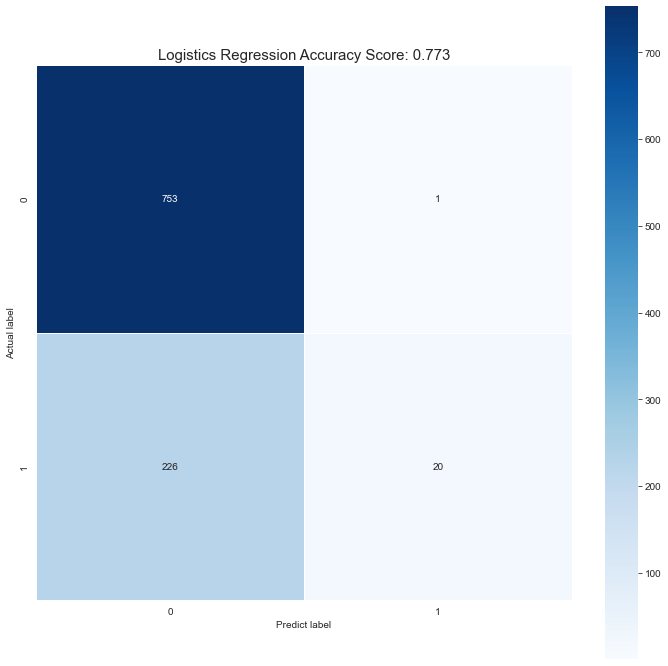

In [102]:
plt.figure(figsize=(12, 12))
sns.heatmap(lo_cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues")
plt.ylabel("Actual label")
plt.xlabel("Predict label")
title = "Logistics Regression Accuracy Score: {0}".format(acc)
plt.title(title, size = 15)